### Load model

In [1]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.set_default_tensor_type(torch.FloatTensor)
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('model_snnet_trained.pkl')

### 700-serum data

In [2]:
import numpy as np
noesypr1d = np.load(r'MTBLS2387_SE003_noesy.npy').reshape(1,-1)
cpmgpr1d = np.load(r'MTBLS2387_SE003_cpmg.npy').reshape(1,-1)
print(noesypr1d.shape, cpmgpr1d.shape)  

(1, 65536) (1, 131072)


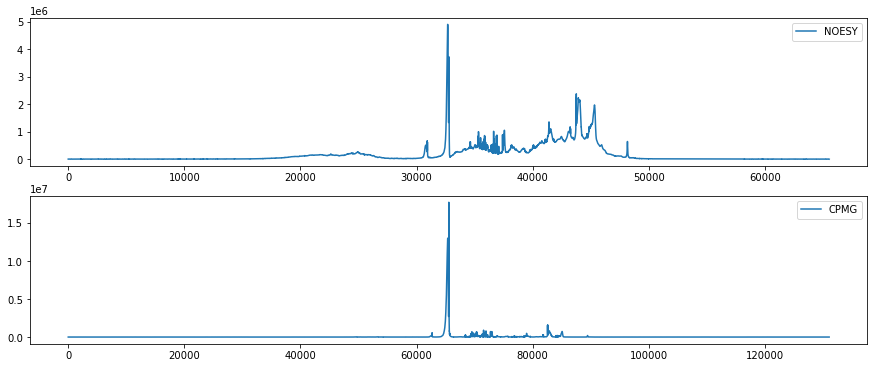

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(noesypr1d[0], label= 'NOESY' )
plt.legend()
plt.subplot(2,1,2)
plt.plot(cpmgpr1d[0] , label= 'CPMG')
plt.legend()
plt.show()

In [4]:
noesypr1d -= noesypr1d[:,40000:60000].min(1).reshape(1,-1)
cpmgpr1d -= cpmgpr1d[:,80000:120000].min(1).reshape(1,-1)
cpmgpr1d /= cpmgpr1d[:,80000:120000].max(1).reshape(-1,1)

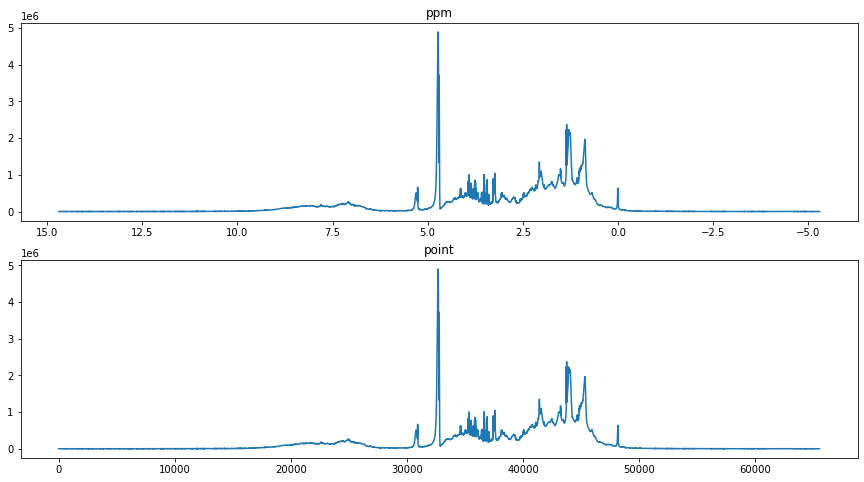

In [5]:
import matplotlib.pyplot as plt
ppm_20 = np.linspace(4.7+10, 4.7-10, 64*1024)
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(ppm_20, noesypr1d[0] )
plt.gca().invert_xaxis()
plt.title('ppm')
plt.subplot(2,1,2)
plt.plot(noesypr1d[0] )
plt.title('point')
plt.show()

In [6]:
left_2, right_2 = 4.7 + 10*600/700, 4.7 - 10*600/700    # 12000 Hz @ 700MHz  

In [7]:
sw_700_20 = np.linspace(int(64*1024/14), 64*1024-int(64*1024/14), 64*1024-2*int(64*1024/14), endpoint=True) 
sw_600_20 = np.linspace(int(64*1024/14), 64*1024-int(64*1024/14), num=int(128*1024), endpoint=True) 
ppm_20 = np.linspace(left_2, right_2, 128*1024)  

In [8]:
sw_700_20.shape, sw_600_20.shape, noesypr1d[0][int(64*1024/14):64*1024-int(64*1024/14)].shape

((56174,), (131072,), (56174,))

In [9]:
# 20 ppm @ 700MHz ----> 20 ppm @ 600MHz 
import time
noesy_20ppm = []
macro_all_n = []
small_all_n = []
model.eval()
start_time = time.time()
with torch.no_grad():
    noesypr1d_10_t = [np.interp(sw_600_20, sw_700_20, data[int(64*1024/14):64*1024-int(64*1024/14)]) for data in noesypr1d]
    noesypr1d_10_t = [(data - data[70000:120000].min())/(data[70000:120000].max()) for data in noesypr1d_10_t]
    
    for spec_data in noesypr1d_10_t:   
        output_n = model(torch.from_numpy(spec_data).reshape(-1,1,128*1024).to(torch.float32).to(device)) 
        noesy_20ppm.append(spec_data)
        macro_all_n.append(output_n.cpu().numpy().reshape(-1,1))
        small_all_n.append(spec_data.reshape(-1,1)-output_n.cpu().numpy().reshape(-1,1))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'cost time {elapsed_time:.6f} secs')     
macro_all_np = np.array(macro_all_n).reshape(-1, 128*1024)
small_all_np = np.array(small_all_n).reshape(-1, 128*1024)
noesy_20ppm_np = np.array(noesy_20ppm).reshape(-1, 128*1024)
print(macro_all_np.shape, small_all_np.shape, noesy_20ppm_np.shape)

cost time 0.681624 secs
(1, 131072) (1, 131072) (1, 131072)


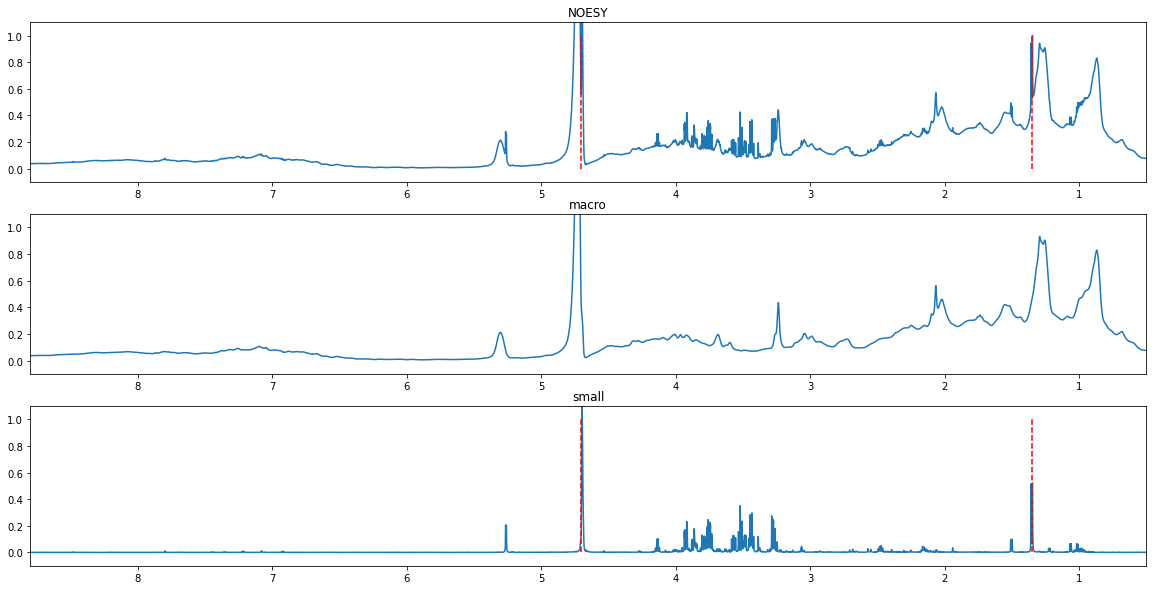

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(ppm_20, noesy_20ppm_np[0])
plt.vlines(1.35, 0, 1, colors='r', linestyles='--')
plt.vlines(4.70, 0, 1, colors='r', linestyles='--')
plt.xlim(8.8, 0.5)
plt.ylim(-0.1,1.1)
plt.title('NOESY')
plt.subplot(3, 1, 2)
plt.plot(ppm_20, macro_all_np[0])
plt.xlim(8.8, 0.5)
plt.ylim(-0.1,1.1)
plt.title('macro')
plt.subplot(3, 1, 3)
plt.plot(ppm_20, small_all_np[0])
plt.vlines(1.35, 0, 1, colors='r', linestyles='--')
plt.vlines(4.70, 0, 1, colors='r', linestyles='--')
plt.xlim(8.8, 0.5)
plt.ylim(-0.1,1.1)
plt.title('small')
plt.show()

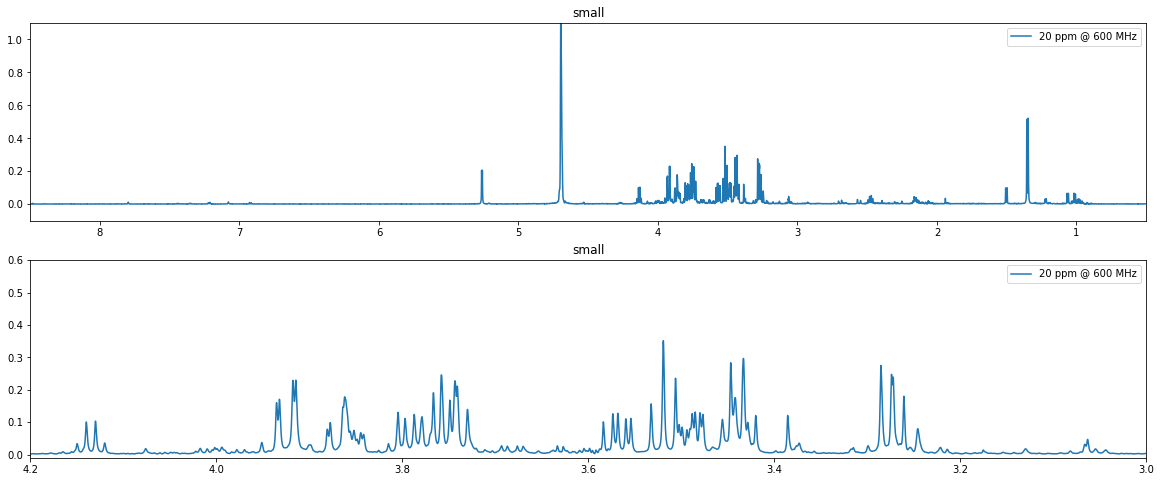

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.plot(ppm_20,  small_all_np[0], label = '20 ppm @ 600 MHz')
plt.xlim(8.5, 0.5)
plt.ylim(-0.1, 1.1)
plt.title('small')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(ppm_20, small_all_np[0], label = '20 ppm @ 600 MHz')
plt.xlim(4.2, 3)
plt.ylim(-0.01, 0.6)
plt.title('small')
plt.legend()
plt.show()

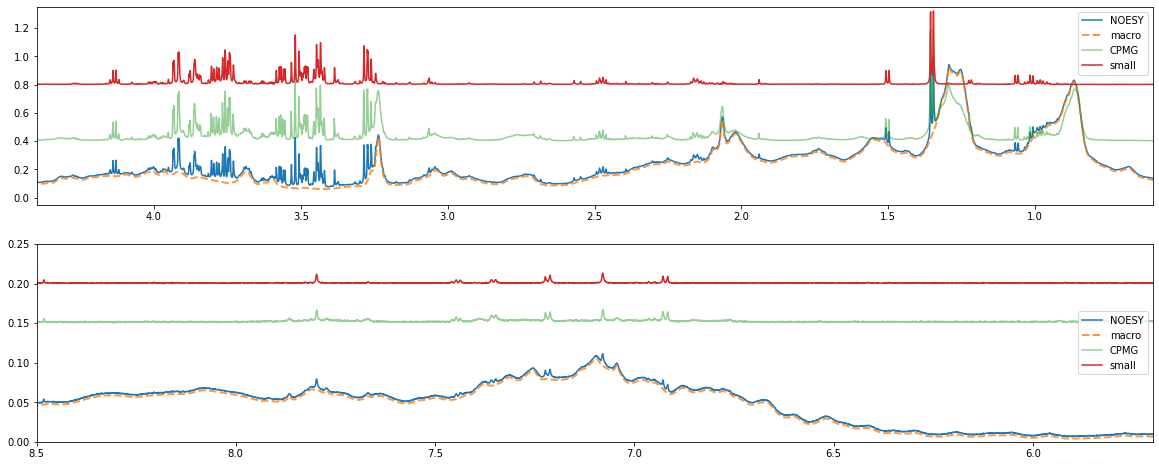

In [12]:
import matplotlib.pyplot as plt
cpmg_sw = np.linspace(4.7+ 25.74/2, 4.7 - 25.74/2, 128*1024)
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(ppm_20, noesy_20ppm_np[0],  label = 'NOESY')
plt.plot(ppm_20, macro_all_np[0]-0.01, label = 'macro', linestyle='--' , alpha = 0.8, linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]*0.8 +0.4, alpha= 0.5, label = 'CPMG')
plt.plot(ppm_20, small_all_np[0]+ 0.8, label = 'small')
plt.xlim(4.4, 0.6)
plt.ylim(-0.05, 1.35)
plt.legend()
plt.subplot(2,1,2)
plt.plot(ppm_20, noesy_20ppm_np[0],  label = 'NOESY')
plt.plot(ppm_20, macro_all_np[0]-0.002, label = 'macro', linestyle='--' , alpha = 0.8, linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]*0.8 +0.15, alpha= 0.5, label = 'CPMG')
plt.plot(ppm_20, small_all_np[0]+0.2 , label = 'small')
plt.xlim(8.5,  5.7)
plt.ylim(-0.0,0.25)
plt.legend()
plt.show()

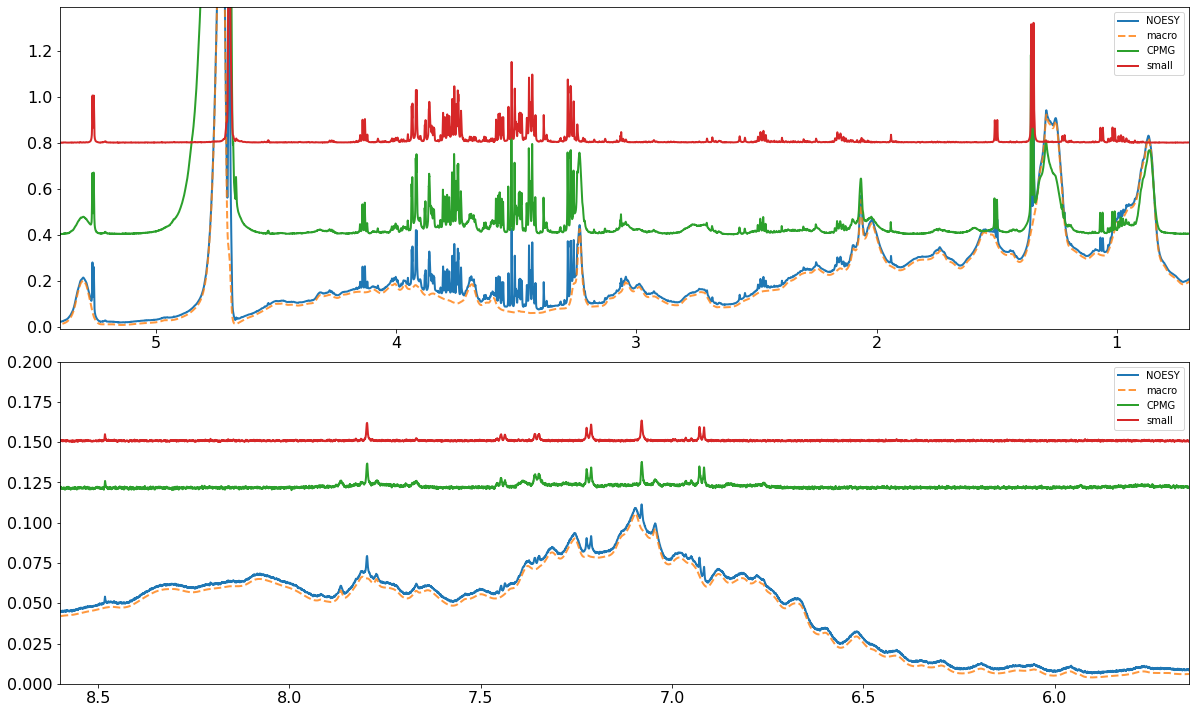

In [13]:
import matplotlib.pyplot as plt
cpmg_sw = np.linspace(4.7+ 25.74/2, 4.7 - 25.74/2, 128*1024)
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(ppm_20, noesy_20ppm_np[0],  label = 'NOESY', linewidth = 2)
plt.plot(ppm_20, macro_all_np[0]-0.01, label = 'macro', linestyle='--' , alpha = 0.8, linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]*0.8 +0.4, label = 'CPMG', linewidth = 2)
plt.plot(ppm_20, small_all_np[0]+ 0.8, label = 'small', linewidth = 2)
plt.xlim(5.4, 0.7)
plt.ylim(-0.01,1.39) 
plt.legend()
plt.tick_params(labelsize=16)
plt.subplot(2,1,2)
plt.plot(ppm_20, noesy_20ppm_np[0],  label = 'NOESY', linewidth = 2)
plt.plot(ppm_20, macro_all_np[0]-0.002, label = 'macro', linestyle='--' , alpha = 0.8, linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]*0.8 +0.12, label = 'CPMG', linewidth = 2)
plt.plot(ppm_20, small_all_np[0]+0.15 , label = 'small', linewidth = 2)
plt.xlim(8.6, 5.65 )
plt.ylim(-0.0,0.2)
plt.legend()
plt.subplots_adjust(top=0.99,bottom=0.05,left=0.01 ,right=0.99,hspace=0.1,wspace=0.2)
plt.tick_params(labelsize=16)
plt.show()

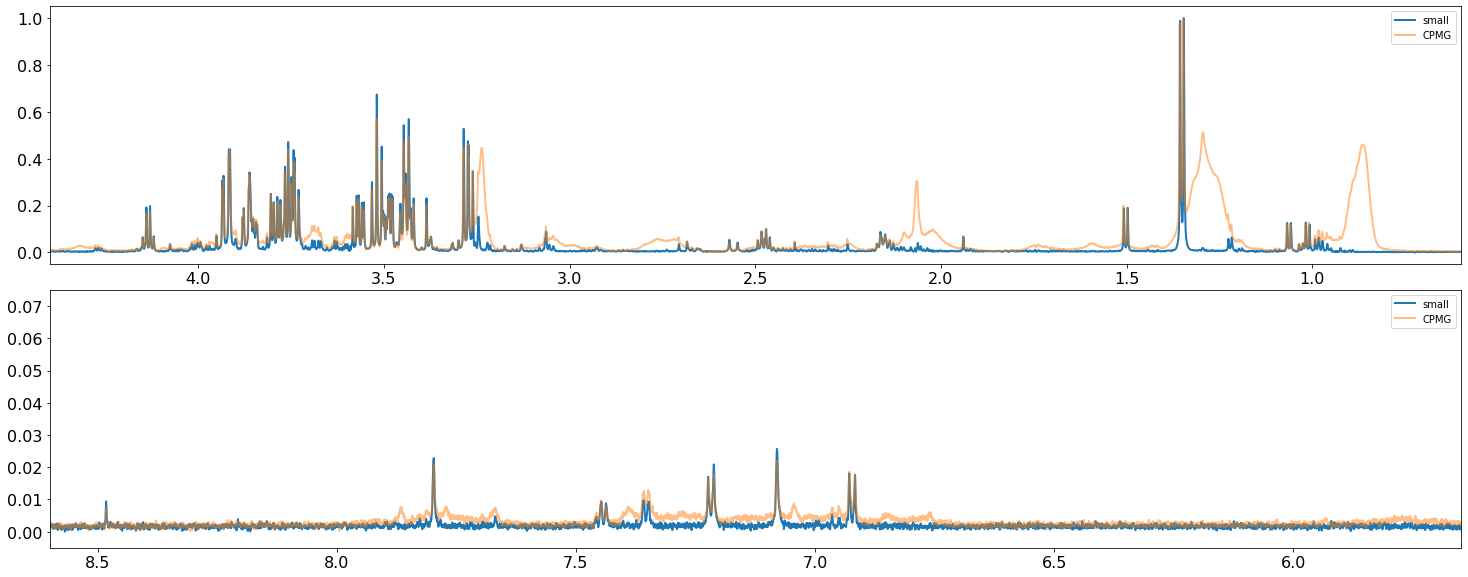

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(ppm_20, small_all_np[0]/small_all_np[0][70000:120000].max(), label = 'small', linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]/cpmgpr1d[0][70000:120000].max(), alpha= 0.5, label = 'CPMG', linewidth = 2)
plt.xlim(4.4, 0.6)
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tick_params(labelsize=16)
plt.subplot(2,1,2)
plt.plot(ppm_20, small_all_np[0]/small_all_np[0][70000:120000].max(), label = 'small', linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]/cpmgpr1d[0][70000:120000].max(), alpha= 0.5, label = 'CPMG', linewidth = 2)
plt.xlim(8.5,  5)
plt.ylim(-0.05,0.45)
plt.xlim(8.6, 5.65 )
plt.ylim(-0.005, 0.075)  
plt.legend()
plt.subplots_adjust(top=0.99,bottom=0.05,left=0.01 ,right=0.99,hspace=0.1,wspace=0.2)
plt.tick_params(labelsize=16)
plt.show()  

### 700-plasma-EDTA data

In [15]:
import numpy as np
noesypr1d = np.load(r'MTBLS2387_PE003_noesy.npy').reshape(1,-1)
cpmgpr1d = np.load(r'MTBLS2387_PE003_cpmg.npy').reshape(1,-1)
noesypr1d -= noesypr1d[:,40000:60000].min(1).reshape(-1,1)
cpmgpr1d -= cpmgpr1d[:,80000:120000].min(1).reshape(-1,1)
cpmgpr1d /= cpmgpr1d[:,70000:120000].max(1).reshape(-1,1)
print(noesypr1d.shape, cpmgpr1d.shape)

(1, 65536) (1, 131072)


In [16]:
# 20 ppm @ 700MHz ----> 20 ppm @ 600MHz 
import time
noesy_20ppm = []
macro_all_n = []
small_all_n = []
model.eval()
start_time = time.time()
with torch.no_grad():
    noesypr1d_10_t = [np.interp(sw_600_20, sw_700_20, data[int(64*1024/14):64*1024-int(64*1024/14)]) for data in noesypr1d]
    noesypr1d_10_t = [(data - data[70000:120000].min()) / (data[70000:120000].max()) for data in noesypr1d_10_t]
    
    for spec_data in noesypr1d_10_t:   
        output_n = model(torch.from_numpy(spec_data).reshape(-1,1,128*1024).to(torch.float32).to(device)) 
        noesy_20ppm.append(spec_data)
        macro_all_n.append(output_n.cpu().numpy().reshape(-1,1))
        small_all_n.append(spec_data.reshape(-1,1)-output_n.cpu().numpy().reshape(-1,1))
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'cost time {elapsed_time:.6f} secs')     
macro_all_np = np.array(macro_all_n).reshape(-1, 128*1024)
small_all_np = np.array(small_all_n).reshape(-1, 128*1024)
noesy_20ppm_np = np.array(noesy_20ppm).reshape(-1, 128*1024)
print(macro_all_np.shape, small_all_np.shape, noesy_20ppm_np.shape)

cost time 0.623054 secs
(1, 131072) (1, 131072) (1, 131072)


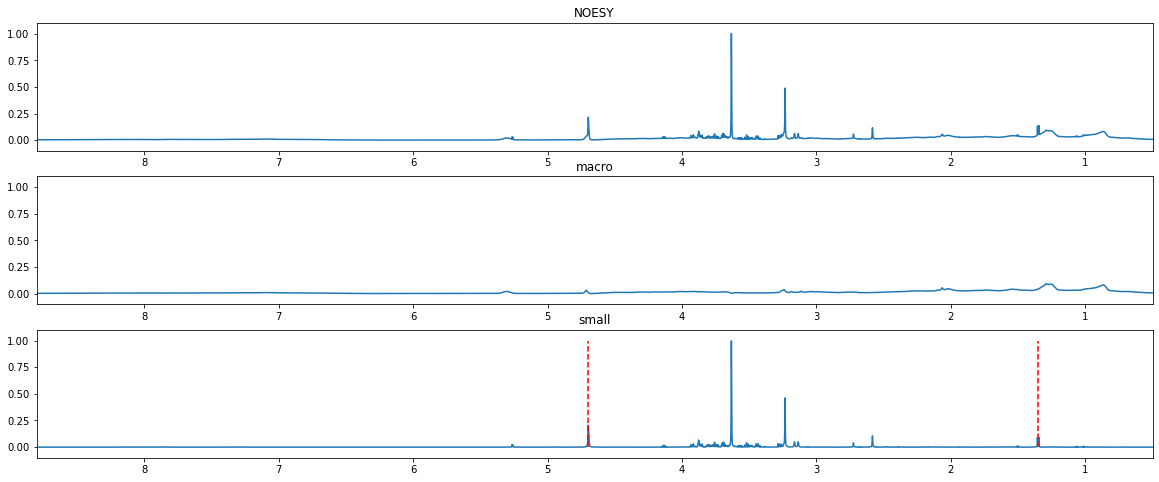

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.subplot(3, 1, 1)
plt.plot(ppm_20, noesy_20ppm_np[0])
plt.xlim(8.8, 0.5)
plt.ylim(-0.1,1.1)
plt.title('NOESY')
plt.subplot(3, 1, 2)
plt.plot(ppm_20, macro_all_np[0])
plt.xlim(8.8, 0.5)
plt.ylim(-0.1,1.1)
plt.title('macro')
plt.subplot(3, 1, 3)
plt.plot(ppm_20, small_all_np[0])
plt.vlines(1.35, 0, 1, colors='r', linestyles='--')
plt.vlines(4.70, 0, 1, colors='r', linestyles='--')
plt.xlim(8.8, 0.5)
plt.ylim(-0.1,1.1)
plt.title('small')
plt.show()

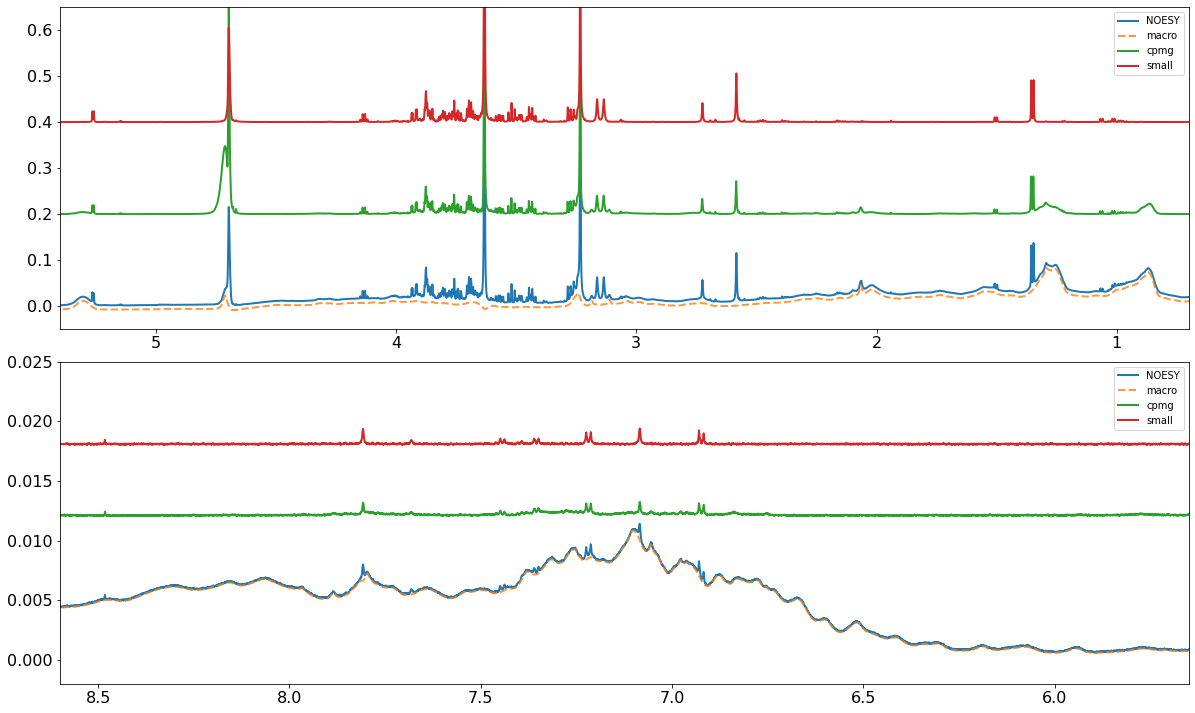

In [18]:
import matplotlib.pyplot as plt
cpmg_sw = np.linspace(4.7+ 25.74/2, 4.7 - 25.74/2, 128*1024)
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(ppm_20, noesy_20ppm_np[0],  label = 'NOESY', linewidth = 2)
plt.plot(ppm_20, macro_all_np[0]-0.009, label = 'macro', linestyle='--' , alpha = 0.8, linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]*0.8 +0.2, label = 'cpmg', linewidth = 2)
plt.plot(ppm_20, small_all_np[0]+ 0.4, label = 'small', linewidth = 2)
plt.xlim(5.4, 0.7)
plt.ylim(-0.05,0.65) 
plt.legend()
plt.tick_params(labelsize=16)
plt.subplot(2,1,2)
plt.plot(ppm_20, noesy_20ppm_np[0],  label = 'NOESY', linewidth = 2)
plt.plot(ppm_20, macro_all_np[0]-0.00 , label = 'macro', linestyle='--' , alpha = 0.8, linewidth = 2)
plt.plot(cpmg_sw, cpmgpr1d[0]*0.8 +0.012, label = 'cpmg', linewidth = 2)
plt.plot(ppm_20, small_all_np[0]+0.018 , label = 'small', linewidth = 2)
plt.xlim(8.6, 5.65 )
plt.ylim(-0.002,0.025)
plt.legend()
plt.subplots_adjust(top=0.99,bottom=0.05,left=0.01 ,right=0.99,hspace=0.1,wspace=0.2)
plt.tick_params(labelsize=16)
plt.show()